In [2]:
#Authors: Céline Hirsch, Sandra Frey, Sina Röllin
#Deep Learning Project: Inclusiveness in Sarcasm Detection

This file contains the process used for the training of the audio model. First, the waveforms had to be extracted from the final utterances mp4 files provided by the dataset and where then saved locally (addition to the git ignore, they can be found in a zip folder called: audio_files). Next the waveforms were transformed to spectrograms, which were also saved locally (addition to git ignore, they can also be found in a zip folder called: spectrograms).

In [4]:
#Importing the necessary libraries
from functions_audio_model import *
from moviepy.editor import VideoFileClip
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from scipy.ndimage import zoom
import numpy as np
import os
import json
import librosa
import timm

In [3]:
#NOT TO BE RE-RUN
#Extraction of the data from the mp4 files and saving them in the audio_files directory

#Provided Videos
video_dir = 'utterances_final/'

#Directory for saving the extracted audio
audio_dir = 'audio_files/'

video_files = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

for video_file in video_files:
    clip = VideoFileClip(os.path.join(video_dir, video_file))
    
    #Extraction of the audio and saving in the audio_files directory
    audio_file = video_file.replace('.mp4', '.wav')
    clip.audio.write_audiofile(os.path.join(audio_dir, audio_file))


#The files are now in waveform format (.wav)

In [ ]:
#NOT TO BE RE-RUN
#Creation of spectrograms from the waveform data extracted above


#Directory containing audio files
audio_dir = 'audio_files/'

#Directory to save spectrograms
spectrogram_dir = 'spectrograms/'

#Length of the maximum waveform found in the dataset
# 1_213.wav
max_length = 882882


for file_name in os.listdir(audio_dir):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_dir, file_name)
        y, sr = librosa.load(file_path)

        #Padding the waveform to the maximum length found
        if len(y) < max_length:
            y_padded = np.pad(y, (0, max_length - len(y)), 'constant')
        else:
            y_padded = y[:max_length]

        #Compute the short-time Fourier transform
        D = librosa.stft(y_padded)

        #Convert the amplitude to decibels (logarithmic scale)
        D_log = librosa.amplitude_to_db(abs(D))

        #Resize the spectrogram to 224x224 -> wanted dimensions for the Beit model
        resize_factor_x = 224 / D_log.shape[1]
        resize_factor_y = 224 / D_log.shape[0]
        D_log_resized = zoom(D_log, (resize_factor_y, resize_factor_x))

        #Conversion to colour image
        D_log_resized_color = plt.get_cmap('viridis')(D_log_resized / np.amax(D_log_resized))

        #Remove the alpha channel of the RGBA image
        D_log_resized_color = D_log_resized_color[:, :, :3]

        #All colour channels saved in the same variable
        red_channel = D_log_resized_color[:, :, 0]
        green_channel = D_log_resized_color[:, :, 1]
        blue_channel = D_log_resized_color[:, :, 2]

        #Save the spectrograms separately for each colour channel
        red_spectrogram_path = os.path.join(spectrogram_dir, file_name.replace('.wav', '_red.npy'))
        green_spectrogram_path = os.path.join(spectrogram_dir, file_name.replace('.wav', '_green.npy'))
        blue_spectrogram_path = os.path.join(spectrogram_dir, file_name.replace('.wav', '_blue.npy'))

        np.save(red_spectrogram_path, red_channel)
        np.save(green_spectrogram_path, green_channel)
        np.save(blue_spectrogram_path, blue_channel)

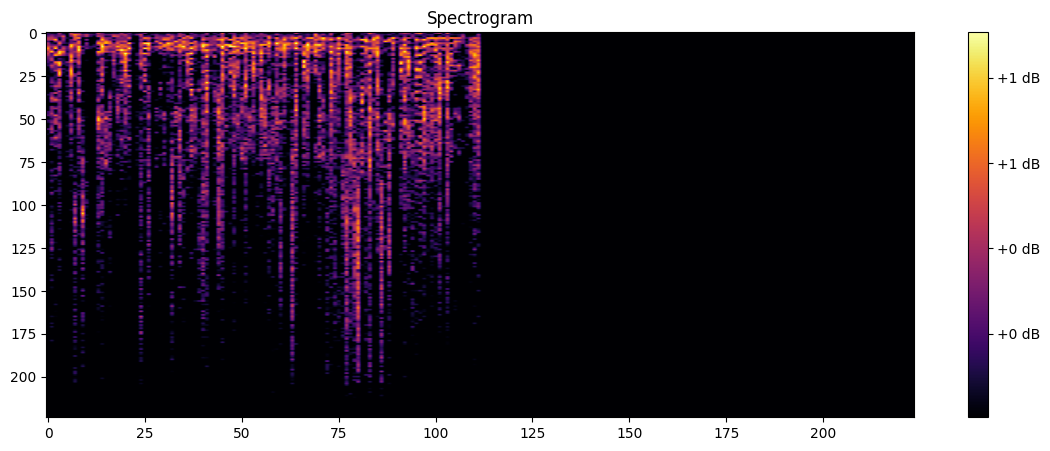

In [67]:
#Example of one of the spectrograms

# Load the spectrogram
spectrogram = np.load('spectrograms/1_213_green.npy')

# Display the spectrogram of just one channel (G)
plt.figure(figsize=(14, 5))
plt.imshow(spectrogram, aspect='auto', cmap='inferno')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [70]:
#Check for the correct dimensions of the spectrograms of one file example

spectrogram1 = np.load('spectrograms/2_627_red.npy')
spectrogram2 = np.load('spectrograms/2_627_green.npy')
spectrogram3 = np.load('spectrograms/2_627_blue.npy')
spectrogram1 = torch.from_numpy(spectrogram1)
spectrogram2 = torch.from_numpy(spectrogram2)
spectrogram3 = torch.from_numpy(spectrogram3)

In [71]:
assert spectrogram1.shape == (224, 224)
assert spectrogram2.shape == (224, 224)
assert spectrogram3.shape == (224, 224)

In [72]:
#Load labels for sarcasm detection (from a different file, not part of the spectrograms folder)
with open('sarcasm_data.json') as f:
    text_data = json.load(f)
    sarcasm_labels = {k: int(v['sarcasm']) for k, v in text_data.items()}

In [39]:
assert len(sarcasm_labels) == 690

In [41]:
sarcasm_labels

{'1_60': 1,
 '1_70': 1,
 '1_80': 0,
 '1_90': 0,
 '1_105': 1,
 '1_162': 0,
 '1_175': 1,
 '1_182': 1,
 '1_213': 1,
 '1_276': 1,
 '1_340': 1,
 '1_410': 0,
 '1_427': 1,
 '1_430': 0,
 '1_467': 0,
 '1_506': 0,
 '1_507': 1,
 '1_533': 0,
 '1_536': 1,
 '1_537': 1,
 '1_672': 0,
 '1_971': 1,
 '1_1001': 0,
 '1_1003': 1,
 '1_1144': 1,
 '1_1180': 1,
 '1_1185': 0,
 '1_1189': 0,
 '1_1262': 0,
 '1_1296': 1,
 '1_1466': 1,
 '1_1470': 0,
 '1_1478': 1,
 '1_1484': 0,
 '1_1549': 1,
 '1_1560': 1,
 '1_1627': 0,
 '1_1638': 1,
 '1_1666': 0,
 '1_1678': 0,
 '1_1722': 0,
 '1_1732': 1,
 '1_1772': 1,
 '1_1798': 1,
 '1_1803': 1,
 '1_1931': 1,
 '1_1973': 1,
 '1_1987': 1,
 '1_2075': 0,
 '1_2119': 1,
 '1_2198': 1,
 '1_2216': 0,
 '1_2354': 1,
 '1_2361': 0,
 '1_2420': 0,
 '1_2423': 0,
 '1_2464': 1,
 '1_2575': 0,
 '1_2580': 1,
 '1_2614': 1,
 '1_2616': 1,
 '1_2664': 0,
 '1_2669': 0,
 '1_2778': 1,
 '1_2792': 0,
 '1_2797': 1,
 '1_2819': 1,
 '1_2830': 0,
 '1_2837': 0,
 '1_2842': 0,
 '1_2853': 1,
 '1_3064': 1,
 '1_3069': 0,
 '1_

In [59]:
# Check for missing files (To assure completeness of both spectrograms and labels not taking colour channels into account)
spectrogram_dir = 'spectrograms/'
missing_files = [label for label in sarcasm_labels if label + '.npy' not in os.listdir(spectrogram_dir)]

print(f'Missing files: {missing_files}')
print(f'Number of missing files: {len(missing_files)}')

Missing files: []
Number of missing files: 0


In [52]:
#Taking colour channels into account
spectrogram_dir = 'spectrograms/'
missing_files_R = [label for label in sarcasm_labels if label + '_red.npy' not in os.listdir(spectrogram_dir)]
missing_files_G = [label for label in sarcasm_labels if label + '_green.npy' not in os.listdir(spectrogram_dir)]
missing_files_B = [label for label in sarcasm_labels if label + '_blue.npy' not in os.listdir(spectrogram_dir)]

print(f'Missing files (R channel): {missing_files_R}')
print(f'Number of missing files (R channel): {len(missing_files_R)}')

print(f'Missing files (G channel): {missing_files_G}')
print(f'Number of missing files (G channel): {len(missing_files_G)}')

print(f'Missing files (B channel): {missing_files_B}')
print(f'Number of missing files (B channel): {len(missing_files_B)}')

Missing files (R channel): []
Number of missing files (R channel): 0
Missing files (G channel): []
Number of missing files (G channel): 0
Missing files (B channel): []
Number of missing files (B channel): 0


In [56]:
#Check the correct number of files
spectrogram_dir = 'spectrograms/'
files = os.listdir(spectrogram_dir)

assert len(files) == 690*4

In [3]:
#The following cells are to be re-run for the training of the audio model

In [73]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os

class SpectrogramDataset(Dataset):
    def __init__(self, spectrogram_dir, labels):
        self.spectrogram_dir = spectrogram_dir
        self.file_list = [f for f in os.listdir(spectrogram_dir) if f.endswith('_red.npy')]
        self.labels = labels  #dictionary mapping base file names to labels

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        #to get the base name of the file (without the color channel)
        base_name = self.file_list[idx].replace('_red.npy', '')

        #All colour channels separately
        red_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_red.npy'))
        green_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_green.npy'))
        blue_channel = np.load(os.path.join(self.spectrogram_dir, base_name + '_blue.npy'))

        #Stack the color channels to create RGB image
        spectrogram = np.stack((red_channel, green_channel, blue_channel), axis=2)

        #Correct the order for Beit model
        spectrogram = np.transpose(spectrogram, (2, 0, 1))

        #Conversion to tensor
        spectrogram = torch.from_numpy(spectrogram)

        #Normalisation
        mean = spectrogram.mean()
        std = spectrogram.std()
        spectrogram = (spectrogram - mean) / std

        #Label
        label = self.labels[base_name]

        return spectrogram, label

In [76]:
#Hyperparameters
learning_rate = 0.0001
#0.001
N_EPOCHS = 15
#5
batchsize = 64
#8

In [77]:
#Initialisation of the dataset
dataset = SpectrogramDataset('spectrograms/', sarcasm_labels)

# Initialize a DataLoader
dataloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)

# Initialize the model
model = timm.create_model('beit_base_patch16_224', pretrained=True)

#add masking??????????? -> for the black part so it ignores it for analysis


In [78]:
#last layer -> classification head
num_ftrs = model.head.in_features

#Binary Classification -> Sarcasm or not
num_classes = 2 

#Replace the last layer with a new one
model.head = nn.Linear(num_ftrs, num_classes)


In [79]:
#Splitting the dataset into training and testing data

train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

#DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize)

In [80]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

# Train the model
# You need to replace `train_cycle` with your actual training function
train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'beit_model_spectrograms.pth')


Epoch 0 of 15


 78%|███████▊  | 7/9 [13:55<03:45, 112.73s/it]

train Loss: 0.3449,  ACC: 0.8194, F1-weighted: 0.8136


100%|██████████| 5/5 [00:42<00:00,  8.40s/it]


eval Loss: 0.7169,  ACC: 0.6400, F1-weighted: 0.6280


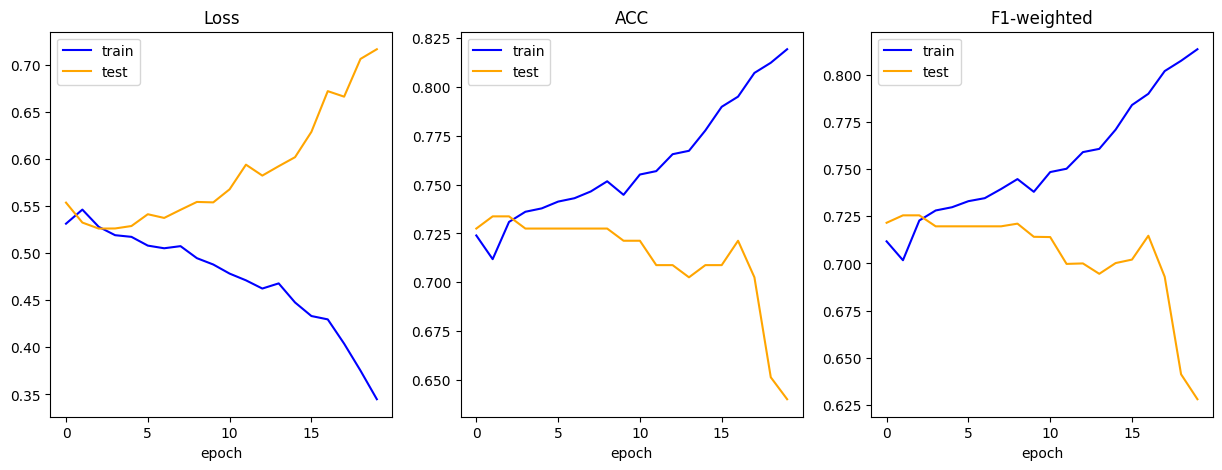

In [19]:
# Seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Create the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss()

#metrics
metrics = {'ACC': acc, 'F1-weighted': f1}

# Train the model
# You need to replace `train_cycle` with your actual training function
train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs=N_EPOCHS, device=device)

# Save the model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'beit_model_spectrograms.pth')
